In [60]:
import xarray as xr
import pandas as pd
%matplotlib inline

In [61]:
rgi_id = 'RGI60-11.01270'

In [62]:
import oggm
from oggm import cfg, utils, tasks, workflow
from oggm.workflow import execute_entity_task

# Initialize OGGM and set up the run parameters
cfg.initialize()

2018-08-02 16:15:38: oggm.cfg: Parameter file: /home/mowglie/Documents/git/oggm-fork/oggm/params.cfg


In [63]:
# Local paths (where to write the OGGM run output)
wdir = 'test_cru_wd'
utils.mkdir(wdir, reset=True)
cfg.PATHS['working_dir'] = wdir
cfg.PARAMS['use_intersects'] = False

In [64]:
rgidf = utils.get_rgi_glacier_entities([rgi_id], version='61')

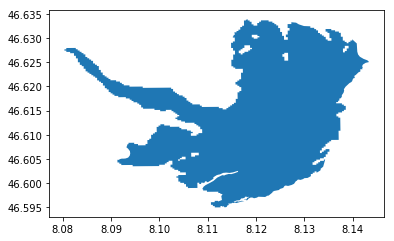

In [65]:
rgidf.plot();

In [66]:
rgidf

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
1269,RGI60-11.01270,G008119E46614N,20030799,20030999,8.11933,46.6143,11,1,9.023,1361,...,6412,0,0,0,0,9,9,None,WARN:WasInvalid;,"POLYGON ((8.127299661000052 46.63327544100008,..."


In [17]:
# Go - initialize working directories
gdirs = workflow.init_glacier_regions(rgidf)

# Prepro tasks
task_list = [
    tasks.glacier_masks,
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.catchment_area,
    tasks.catchment_intersections,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
]
# execute all tasks
for task in task_list:
    execute_entity_task(task, gdirs)

2018-08-02 15:48:42: oggm.workflow: Multiprocessing: using all available processors (N=8)
2018-08-02 15:48:42: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2018-08-02 15:48:42: oggm.core.gis: (RGI60-11.01270) glacier_masks
2018-08-02 15:48:42: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2018-08-02 15:48:42: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2018-08-02 15:48:42: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2018-08-02 15:48:43: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2018-08-02 15:48:43: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2018-08-02 15:48:43: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction


In [18]:
tasks.process_cru_data(gdirs[0])

2018-08-02 15:49:09: oggm.core.climate: (RGI60-11.01270) process_cru_data


In [19]:
gdir = gdirs[0]

In [21]:
gdir.get_filepath('climate_monthly')

'mb_calib_wd/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01270/climate_monthly.nc'

In [22]:
cp mb_calib_wd/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01270/climate_monthly.nc climate_cru.nc

In [23]:
# set path to HISTALP climate file
cfg.PATHS['climate_file'] = 'raw_data/histalp_merged_full.nc'
# Climate tasks
execute_entity_task(tasks.process_custom_climate_data, gdirs)

2018-08-02 15:51:28: oggm.workflow: Multiprocessing: using all available processors (N=8)
2018-08-02 15:51:28: oggm.core.climate: (RGI60-11.01270) process_custom_climate_data


In [24]:
gdir.get_filepath('climate_monthly')

'mb_calib_wd/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01270/climate_monthly.nc'

In [25]:
cp mb_calib_wd/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01270/climate_monthly.nc climate_hs.nc

In [26]:
dsh = xr.open_dataset('climate_hs.nc')
dsc = xr.open_dataset('climate_cru.nc')

In [29]:
dsc.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prcp     float64 150.5
    temp     float64 -2.002
    grad     float64 -0.0065

In [30]:
dsh.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prcp     float64 178.1
    temp     float64 1.742
    grad     float64 -0.0065

In [32]:
df = dsc.to_dataframe()

In [33]:
dfh = dsh.to_dataframe()

In [35]:
df.columns = ['cru_' + c for c in df.columns]

In [36]:
dfh.columns = ['ha_' + c for c in dfh.columns]

In [41]:
df = pd.concat([df, dfh], axis=1)

In [46]:
df = df.dropna()

In [50]:
dfa = df.resample('AS').mean()

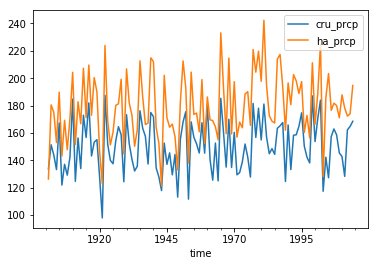

In [51]:
dfa[['cru_prcp', 'ha_prcp']].plot();

In [52]:
dfa.corr()

,cru_prcp,cru_temp,cru_grad,ha_prcp,ha_temp,ha_grad
cru_prcp,1.000000,-0.009546,NaN,0.850970,-0.081037,NaN
cru_temp,-0.009546,1.000000,NaN,0.001074,0.962209,NaN
cru_grad,NaN,NaN,NaN,NaN,NaN,NaN
ha_prcp,0.850970,0.001074,NaN,1.000000,-0.034020,NaN
ha_temp,-0.081037,0.962209,NaN,-0.034020,1.000000,NaN
ha_grad,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
dfa.rolling(10, center=True).mean().corr()

,cru_prcp,cru_temp,cru_grad,ha_prcp,ha_temp,ha_grad
cru_prcp,1.000000,0.236922,NaN,0.792937,0.262135,NaN
cru_temp,0.236922,1.000000,NaN,0.224882,0.987411,NaN
cru_grad,NaN,NaN,NaN,NaN,NaN,NaN
ha_prcp,0.792937,0.224882,NaN,1.000000,0.256669,NaN
ha_temp,0.262135,0.987411,NaN,0.256669,1.000000,NaN
ha_grad,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
dfa.mean()

cru_prcp    150.417603
cru_temp     -2.049710
cru_grad     -0.006500
ha_prcp     179.248566
ha_temp       1.935600
ha_grad      -0.006500
dtype: float32

In [58]:
179.24 / 150.417603 

1.1916158509719104

In [59]:
# Histapl is 20% more precip

In [9]:
dsh = xr.open_dataset('raw_data/histalp_merged_full.nc')

In [10]:
dsc = xr.open_dataset(utils.get_cru_file?)

SyntaxError: invalid syntax (<ipython-input-10-27a2fde8af0a>, line 1)

In [11]:
utils.get_

Signature: utils.get_cru_file(var=None)
Docstring:
Returns a path to the desired CRU TS file.

If the file is not present, download it.

Parameters
----------
var: 'tmp' or 'pre'

Returns
-------
path to the CRU file
File:      ~/Documents/git/oggm-fork/oggm/utils.py
Type:      function
